# Lecture 5: Monte Carlo Methods

In [1]:
import numpy as np
import rldurham as rld

## Learning a Policy with Monte Carlo Sampling

Our goal is to learn an optimal policy from randomly sampled trajectories. Our strategy is to estimate Q-values (state-action values) based on the samples and get the policy from the Q-values.

### Essential Components

We can **define the policy** based on the Q-values by either deterministically picking an action (not a good idea) or giving equal probability to all actions with maximum value. Additionally, we can add uniform random actions with probability epsilon (exploration).

In [2]:
def epsilon_greedy_policy(Q, epsilon, deterministic):
    p = np.zeros_like(Q)
    ns, na = Q.shape
    for s in range(ns):
        Qs = Q[s]
        if deterministic:
            max_action = np.argmax(Qs)
            p[s, max_action] = 1
        else:
            max_actions = np.argwhere(Qs == Qs.max())
            p[s, max_actions] = 1 / len(max_actions)
        p[s] = (1 - epsilon) * p[s] + epsilon / na
    return p

Given a policy, we can **sample episodes** in the environment, that is, complete trajectories that reach the goal state (or run over the time limit).

In [3]:
def sample_episode(env, policy):
    observation, info = env.reset()
    done = False
    trajectory = []
    while not done:
        action = np.random.choice(env.action_space.n, p=policy[observation])
        new_observation, reward, term, trunc, info = env.step(action)
        trajectory.append((observation, action, reward))
        observation = new_observation
        done = term or trunc
    return trajectory, info

From the trajectory, we can **compute returns** (discounted cumulative rewards) for each state along the way, which is most efficiently done in reverse order.

In [4]:
def compute_returns(trajectory, gamma):
    partial_return = 0.
    returns = []
    for observation, action, reward in reversed(trajectory):
        partial_return *= gamma
        partial_return += reward
        returns.append((observation, action, partial_return))
    return list(reversed(returns))

Frome the returns, we can now **update the Q-values** using empirical averages as a Monte Carlo approximation of the expected return. This can be done using exact averages or exponentially smoothing averages (with constant learning rate alpha).

In [5]:
def update_Q(Q, ns, returns, alpha):
    for obs, act, ret in returns:
        ns[obs, act] += 1             # update counts
        if alpha is None:
            alpha = 1 / ns[obs, act]  # use exact means if no learning rate provided
            Q[obs, act] += alpha * (ret - Q[obs, act])
        else:
            old_bias_correction = 1 - (1 - alpha) ** (ns[obs, act] - 1)
            new_bias_correction = 1 - (1 - alpha) ** ns[obs, act]
            Q[obs, act] = Q[obs, act] * old_bias_correction  # undo old bias correction
            Q[obs, act] += alpha * (ret - Q[obs, act])       # normal update as above
            Q[obs, act] = Q[obs, act] / new_bias_correction  # apply new bias correction

### Some Examples

Let's look at different scenarios starting with an empty lake and going through different hyper-parameter settings:

**Empty Lake**

1. **epsilon, gamma, det, alpha = 0.0, 1.0, True,  None**

   A deterministic policy without exploration typically does not learn at all because it never reaches the goal state.

2. **epsilon, gamma, det, alpha = 0.0, 1.0, False, None**

   A non-deterministic policy without exploration samples a successful episode at some point but then "clings" to it without exploring further, so is likely to get stuck and never find the optimal policy.

4. **epsilon, gamma, det, alpha = 0.1, 1.0, False, None**

   A little exploration produces much more stable results and will eventually find the optimal policy. Without any discount it will not have a preference to shorter (or even finite) paths.

5. **epsilon, gamma, det, alpha = 0.5, 0.9, False, None**

   Considerable exploration and some discount produces very stable results with a preference for shorter paths, but the policy is far from optimal due to exploration.

**8x8 Lake**

- Things are more difficult because there are more "pockets" to explore.

**Exploration Noise**

- Run **epsilon, gamma, det, alpha = 0.5, 1.0, False, None** on small custom environment (`slippery=True`) for 1000 episodes
    - With these estimates, the optimal policy avoids the long path, because it is risky due to exploration exploration noise.
- Switch to **epsilon, alpha = 0.4, 0.01** and anneal exploration
    - The long path now becomes preferrable as risk can be better controlled.

Seed set to 42


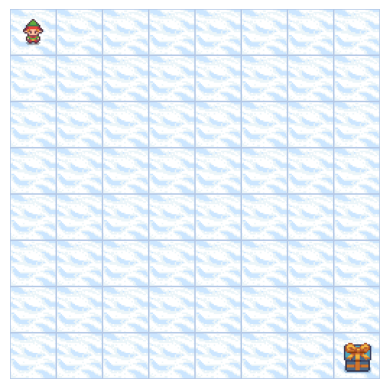

In [6]:
# set up environment
env = rld.make(
    'FrozenLake-v1',     # simple
    # 'FrozenLake8x8-v1',  # more complex
    desc = [             # empty lake (start with this as it is most insightful)
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFFFFFF",
        "FFFFFFFF",
        "FFFFFFFF",
        "FFFFFFFF",
        "FFFFFFFF",
        "FFFFFFFG",
    ],
    is_slippery=False,
    # desc=[               # short high-risk versus long low-risk paths with is_slippery=True
    #     "FFF",
    #     "FHF",
    #     "SFG",
    #     "FHF",
    # ],
    # is_slippery=True,
    render_mode="rgb_array", 
    )
LEFT, DOWN, RIGHT, UP = 0, 1, 2, 3
env = rld.Recorder(env, smoothing=100)
tracker = rld.InfoTracker()
rld.seed_everything(42, env)
rld.render(env)

# initialise Q values
Q = np.zeros((env.observation_space.n, env.action_space.n))
ns = np.zeros((env.observation_space.n, env.action_space.n), dtype=int)

# different hyper parameters
epsilon, gamma, det, alpha = 0.0, 1.0, True,  None  # does not learn at all
# epsilon, gamma, det, alpha = 0.0, 1.0, False, None  # very instable and gets stuck quickly
# epsilon, gamma, det, alpha = 0.1, 1.0, False, None  # more stable but no preference for shorter paths
# epsilon, gamma, det, alpha = 0.5, 0.9, False, None  # stable and preference for shorter paths, but non-optimal policy
# epsilon, gamma, det, alpha = 0.5, 1.0, False, None  # sub-optimal policy due to exploration noise (on small custom map)

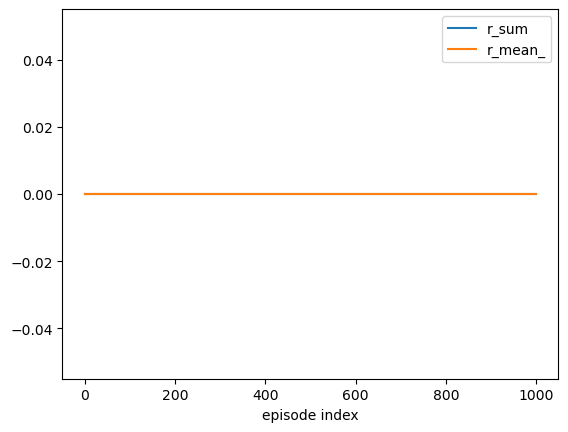

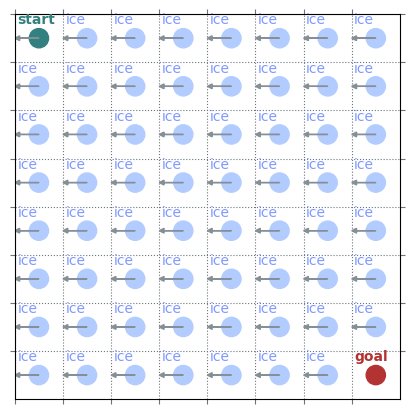

In [7]:
# sample episodes
# n_episodes, plot_every = 1, 1       # one trial at a time
n_episodes, plot_every = 1000, 100  # many trials at once
# epsilon = 0.                        # force optimal policy
# epsilon, alpha = 0.4, 0.01          # less exploration, some forgetting
for eidx in range(n_episodes):
    # epsilon-greedy policy
    policy = epsilon_greedy_policy(Q=Q, epsilon=epsilon, deterministic=det)
    
    # sample complete episode
    trajectory, info = sample_episode(env=env, policy=policy)
    
    # compute step-wise returns from trajectory
    returns = compute_returns(trajectory=trajectory, gamma=gamma)
    
    # update Q values
    update_Q(Q=Q, ns=ns, returns=returns, alpha=alpha)

    # track and plot progress
    tracker.track(info)
    if (eidx + 1) % plot_every == 0:
        tracker.plot(r_sum=True, r_mean_=True, clear=True)
        rld.plot_frozenlake(env, v=Q.max(axis=1), 
                            policy=epsilon_greedy_policy(Q=Q, epsilon=epsilon, deterministic=det), 
                            trajectory=trajectory, draw_vals=True)

In [8]:
# Custom Map
# start state: 6
# LEFT, DOWN, RIGHT, UP = 0, 1, 2, 3
Q[6]

array([0., 0., 0., 0.])

In [9]:
# LEFT, DOWN, RIGHT, UP = 0, 1, 2, 3
print("First steps (state, action, reward):\n", trajectory[:3])
print("First returns (state, action, return):\n", returns[:3])
print("Q values for first states:\n", Q[:3])
print("Action counts for first states:\n", ns[:3])

First steps (state, action, reward):
 [(0, 0, 0.0), (0, 0, 0.0), (0, 0, 0.0)]
First returns (state, action, return):
 [(0, 0, 0.0), (0, 0, 0.0), (0, 0, 0.0)]
Q values for first states:
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Action counts for first states:
 [[100000      0      0      0]
 [     0      0      0      0]
 [     0      0      0      0]]
